<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/4%20-%20La%20Classificazione/binary_classification_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Riconoscimento di tumori al seno maligni

Nello specifico, devi creare un modello di classificazione, in grado di riconoscere i tumori maligni, che:

1. Ha un accuracy sul set di test di almeno 0.98.
2. Ha un AUC sul set di test di almeno 0.98.
2. Ha un recall di 1 (0 falsi positivi).

Per valutare il modello, devi ricreare le seguenti visualizzazioni:

<img src="https://raw.githubusercontent.com/ProfAI/machine-learning-fondamenti/main/4%20-%20La%20Classificazione/res/cancer_classifier_cm.png" width="400px"/>

<img src="https://raw.githubusercontent.com/ProfAI/machine-learning-fondamenti/main/4%20-%20La%20Classificazione/res/cancer_classifier_auc.png" width="400px"/>


Una volta fatto, fornisci le previsioni per questi dati, salvando in un file excel le seguenti informazioni:
1. L'ID paziente
2. La previsione del modello
3. La probabilità associata alla classe predetta

## Soluzione

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay

### Importiamo il dataset

In [3]:
BASE_URL="https://raw.githubusercontent.com/ProfAI/machine-learning-fondamenti/main/datasets/"
df = pd.read_csv(BASE_URL+"breast_cancer.csv")
df.head()

,ID number,diagnosis,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worstse,compactness worst,concavity worst,concave points worst,symmetry worst,fractal dimension worst
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [4]:
df = df.drop("ID number", axis=1) #informazione inutile per la creazione di un modello

In [5]:
counts = df["diagnosis"].value_counts()
print(f"Benignant = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%) ")
print(f"Malignant = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%) ")

Benignant = 353 (62.70%) 
Malignant = 210 (37.30%) 


In [6]:
map_dict = {"M":1, "B":0}
df["diagnosis"] = df["diagnosis"].map(lambda x: map_dict[x])
df.head()

,diagnosis,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,symmetry mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worstse,compactness worst,concavity worst,concave points worst,symmetry worst,fractal dimension worst
0,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,1,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


### Creiamo il modello

In [7]:
X = df.drop("diagnosis", axis=1).values
y = df["diagnosis"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [8]:
ss = StandardScaler()

#Standardizzazione
X_train = ss.fit_transform(X_train) 
X_test = ss.transform(X_test)

In [9]:
lr = LogisticRegression(class_weight="balanced") #abbiamo classi sbilanciate, 
# quindi assegniamo un peso in proporzione alla frequenza delle classi nel dataset.
# In questo modo si avrà un bilanciamento delle classi

lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

### Valutiamo il modello

In [10]:
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       248
           1       0.98      0.97      0.98       146

    accuracy                           0.98       394
   macro avg       0.98      0.98      0.98       394
weighted avg       0.98      0.98      0.98       394

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       105
           1       0.95      0.98      0.97        64

    accuracy                           0.98       169
   macro avg       0.97      0.98      0.97       169
weighted avg       0.98      0.98      0.98       169



La recall non è uguale a 1.

Quando usiamo il metodo predict, si usa di default il valore di threshold 0.5 per dire se una previsione è positiva o negativa.

In questo dato che è piu importante ridurre i falsi negativi rispetto ai falsi positivi possiamo impostare noi un valore di threshold più basso. Es. 0.25.
Possiamo farlo con la funzione 'where' di numpy. 

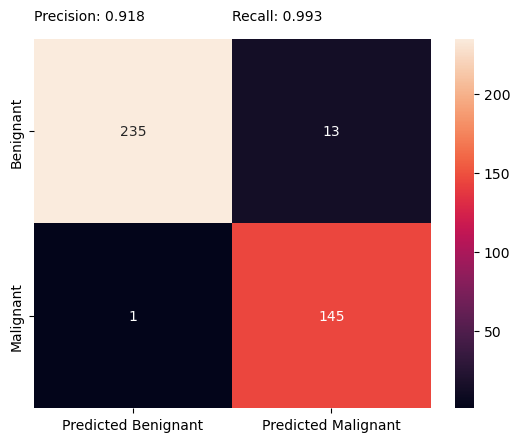

In [25]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall=True):

  cm = confusion_matrix(y_true, y_pred) # tn, fp, fn, tp 

  df_cm = pd.DataFrame(cm, index = labels,
                    columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
  sns.heatmap(df_cm, annot=True, fmt='g')

  if show_precision_recall:
    # Quale percentuale di classificazione positive erano effettivamente positive ?
    plt.text(0, -0.1, f"Precision: {(cm[1][1]/(cm[1][1]+cm[0][1])):.3f}")
    # Quale percentuale di osservazioni positive sono state classificate come positive ?
    plt.text(1, -0.1, f"Recall: {(cm[1][1]/(cm[1][1]+cm[1][0])):.3f}")


y_pred_train = np.where(y_proba_train[:,1]>0.25,1,0) #selezioniamo solo la seconda colonna, la classe positiva.
plot_confusion_matrix(y_train, y_pred_train, ["Benignant", "Malignant"])

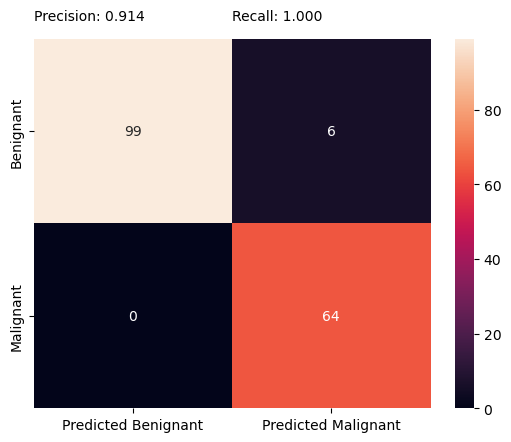

In [27]:
y_pred_test = np.where(y_proba_test[:,1]>0.25,1,0)
plot_confusion_matrix(y_test, y_pred_test, ["Benignant", "Malignant"])

In [28]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       105
           1       0.91      1.00      0.96        64

    accuracy                           0.96       169
   macro avg       0.96      0.97      0.96       169
weighted avg       0.97      0.96      0.96       169



Recall = 1 !

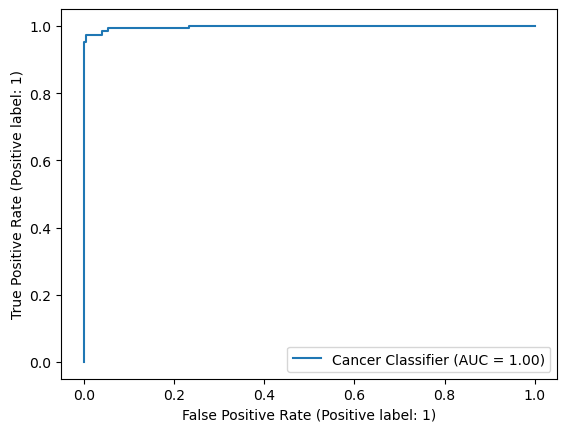

In [14]:
RocCurveDisplay.from_estimator(lr, X_train, y_train, name="Cancer Classifier")

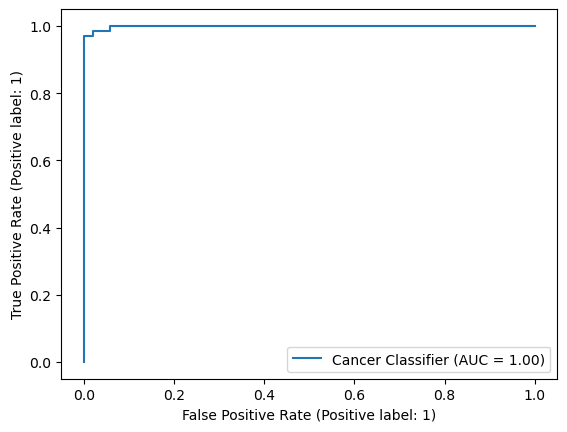

In [15]:
RocCurveDisplay.from_estimator(lr, X_test, y_test, name="Cancer Classifier")

### Eseguiamo le previsioni

In [16]:
df_pred = pd.read_csv(BASE_URL+"breast_cancer_pred.csv")
df_pred.head()

,ID number,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,symmetry mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worstse,compactness worst,concavity worst,concave points worst,symmetry worst,fractal dimension worst
0,842302,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.66560,0.71190,0.26540,0.4601,0.11890
1,8510426,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,...,15.11,19.26,99.70,711.2,0.1440,0.17730,0.23900,0.12880,0.2977,0.07259
2,8510653,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,0.1967,...,14.50,20.49,96.09,630.5,0.1312,0.27760,0.18900,0.07283,0.3184,0.08183
3,8510824,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,...,10.23,15.66,65.13,314.9,0.1324,0.11480,0.08867,0.06227,0.2450,0.07773
4,859487,12.780,16.49,81.37,502.5,0.09831,0.05234,0.03653,0.02864,0.1590,...,13.46,19.76,85.67,554.9,0.1296,0.07061,0.10390,0.05882,0.2383,0.06410


In [17]:
X = df_pred.drop("ID number", axis=1).values
X = ss.transform(X) # Standardizzazione con il transformer di prima!

In [18]:
y_proba = lr.predict_proba(X)
y_pred = np.where(y_proba[:,1]>0.3,1,0)

In [29]:
y_pred #secondo il modello è maligno solo il primo

array([1, 0, 0, 0, 0])

In [19]:
df_result = pd.DataFrame({
    "ID number":df_pred["ID number"],
    "prediction":y_pred,
    "probability":y_proba.max(axis=1).round(4)  #prendiamo la probabilità maggiore
})

df_result.to_excel("breast_cancer_prediction.xlsx")